## Introduction

The code is an implementation for the the paper:  **Hiding Images in Plain Sight: Deep Steganography**. The paper is available [here](https://papers.nips.cc/paper/6802-hiding-images-in-plain-sight-deep-steganography).

This code is learnt from an open-source project. The project is available [here](https://github.com/alexandremuzio/deep-steg). 

In [18]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *
from random import sample
import plot

%matplotlib inline

## Config

In [19]:
### Constants ###
data_dir = "."
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

img_shape = (256, 256)

## Dataset creation
The Training and Validation dataset is from [here](https://www.kaggle.com/gaz3ll3/optimization-ii-project-3).

The Testing dataset is from [here](http://r0k.us/graphics/kodak/).

In [3]:
def load_dataset_small(train_dir, test_dir, img_shape):
    X_train = []
    X_test = []
    
    # Create training set.
    for sub in os.listdir(train_dir):
        sub_dir = os.path.join(train_dir, sub)
        c_imgs = os.listdir(sub_dir)
        for img_name_i in c_imgs:
            try:
                img_i = image.load_img(os.path.join(sub_dir, img_name_i), target_size=img_shape)
                x = image.img_to_array(img_i)
                X_train.append(x)
            except Exception as e:
                print(str(e))
                continue
    
    # Create test set.
    test_dir = os.path.join(test_dir)
    test_imgs = os.listdir(test_dir)
    for img_name_i in test_imgs:
        img_i = image.load_img(os.path.join(test_dir, img_name_i), target_size=img_shape)
        x = image.img_to_array(img_i)
        X_test.append(x)
    
    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [4]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small(train_dir, test_dir, img_shape)

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

train_index = sample([i for i in range(len(X_train))], int(len(X_train)*0.8))
valid_index = list(set(i for i in range(len(X_train))) - set(train_index))
X_valid = X_train[valid_index]
X_train = X_train[train_index]

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of validation examples = " + str(X_valid.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).
print ("X_valid shape: " + str(X_valid.shape)) # Should be (train_size, 64, 64, 3).

cannot identify image file <_io.BytesIO object at 0x0000026100A9ED60>
cannot identify image file <_io.BytesIO object at 0x0000026113989D10>
cannot identify image file <_io.BytesIO object at 0x0000026113980860>
cannot identify image file <_io.BytesIO object at 0x00000261139809A0>
cannot identify image file <_io.BytesIO object at 0x0000026113762680>
cannot identify image file <_io.BytesIO object at 0x0000026113964860>
cannot identify image file <_io.BytesIO object at 0x00000261139647C0>
cannot identify image file <_io.BytesIO object at 0x0000026113779630>
Number of training examples = 2150
Number of validation examples = 538
Number of test examples = 2150
X_train shape: (2150, 256, 256, 3)
X_valid shape: (538, 256, 256, 3)


In [5]:
# We split training set and validation set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

valid_S = X_valid[0:X_valid.shape[0] // 2]
valid_C = X_valid[X_valid.shape[0] // 2:]

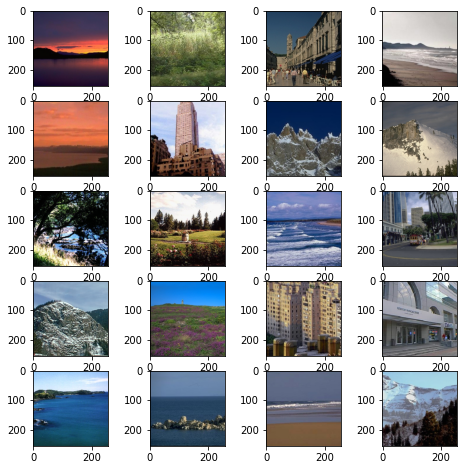

In [6]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

## Model

In [20]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * root_mean_squared_error(s_true, s_pred)

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = root_mean_squared_error(c_true, c_pred)
    
    return s_loss + c_loss

In [21]:
# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    #x = concatenate([input_C, x3, x4, x5])
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_C = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_C,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_S = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    return Model(inputs=reveal_input, outputs=output_S, name = 'Decoder')

def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_C = encoder([input_S, input_C])
    output_S = decoder(output_C)

    full_model = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_S, output_C]))
    full_model.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, full_model

In [22]:
encoder, decoder, full_model = make_model(input_S.shape[1:])

## Training

If the code cannot be trained on your local pc, please find the deep_steg.py file in the same repository and upload the file to
a sever to train the model.

In [10]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [11]:
description = 'Epoch {} | Batch: {:3} of {}. Training loss FM {:10.2f} DE {:10.2f} | Validation loss FM {:10.2f} EN {:10.2f} DE {:10.2f}'

epoches = 1000
batch_size = 32

m = input_S.shape[0]
train_fm_loss_history = []
train_de_loss_history = []
valid_fm_loss_history = []
valid_en_loss_history = []
valid_de_loss_history = []

In [ ]:
for epoch in range(epoches):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], batch_size), mininterval=0)
    train_fm_loss_l = []
    train_de_loss_l = []
    
    valid_fm_loss_l = []
    valid_en_loss_l = []
    valid_de_loss_l = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + batch_size, m)]
        batch_C = input_C[idx:min(idx + batch_size, m)]
        
        C_prime = encoder.predict([batch_S, batch_C])
        
        train_fm_loss_l.append(full_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        train_de_loss_l.append(decoder.train_on_batch(x=C_prime,
                                              y=batch_S))
        
        decoded = full_model.predict([valid_S, valid_C])
        decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
        
        
        valid_fm_loss_l.append(full_loss(np.concatenate((valid_S, valid_C),axis=3), decoded))
        valid_en_loss_l.append(root_mean_squared_error(decoded_C, valid_C))
        valid_de_loss_l.append(rev_loss(valid_S, decoded_S))

        # Update learning rate
        K.set_value(full_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(decoder.optimizer.lr, lr_schedule(epoch))
        
        t.set_description(description.format(epoch + 1, idx, m, np.mean(train_fm_loss_l), np.mean(train_de_loss_l), np.mean(valid_fm_loss_l), np.mean(valid_en_loss_l), np.mean(valid_de_loss_l)))
    train_fm_loss_history.append(np.mean(train_fm_loss_l))
    train_de_loss_history.append(np.mean(train_de_loss_l))
    valid_fm_loss_history.append(np.mean(valid_fm_loss_l))
    valid_en_loss_history.append(np.mean(valid_en_loss_l))
    valid_de_loss_history.append(np.mean(valid_de_loss_l))

  0%|                                                                                           | 0/34 [00:00<?, ?it/s]

In [125]:
# Save model
full_model.save_weights('models/weights.hdf5')

In [25]:
# save the losses
np.savetxt("models/train_fm_loss_history.txt", train_fm_loss_history, delimiter=",")
np.savetxt("models/train_de_loss_history.txt", train_de_loss_history, delimiter=",")
np.savetxt("models/valid_fm_loss_history.txt", valid_fm_loss_history, delimiter=",")
np.savetxt("models/valid_en_loss_history.txt", valid_en_loss_history, delimiter=",")
np.savetxt("models/valid_de_loss_history.txt", valid_de_loss_history, delimiter=",")

In [24]:
# Load model
full_model.load_weights('models/weights.hdf5')

In [34]:
# load losses
train_fm_loss_history = np.loadtxt("models/train_fm_loss_history.txt", delimiter=",")
train_de_loss_history = np.loadtxt("models/train_de_loss_history.txt", delimiter=",")
valid_fm_loss_history = np.loadtxt("models/valid_fm_loss_history.txt", delimiter=",")
valid_en_loss_history = np.loadtxt("models/valid_en_loss_history.txt", delimiter=",")
valid_de_loss_history = np.loadtxt("models/valid_de_loss_history.txt", delimiter=",")

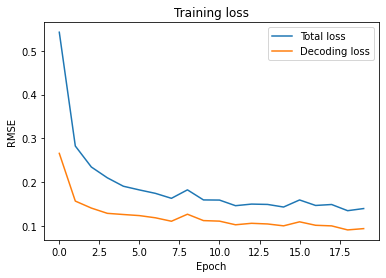

In [44]:
# Plot loss through epochs
plt.plot(train_fm_loss_history, label = "Total loss")
plt.plot(train_de_loss_history, label = "Decoding loss")
plt.title('Training loss')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

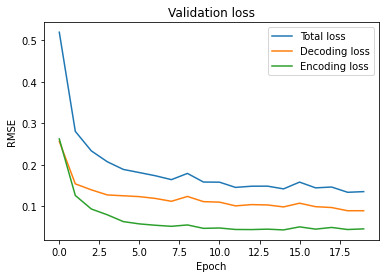

In [43]:
# Plot loss through epochs
plt.plot(valid_fm_loss_history, label = "Total loss")
plt.plot(valid_de_loss_history, label = "Decoding loss")
plt.plot(valid_en_loss_history, label = "Encoding loss")
plt.title('Validation loss')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Test the model on the testing data

In [25]:
test_S = X_test[0:X_test.shape[0] // 2]

# C: cover image
test_C = X_test[X_test.shape[0] // 2:]

In [26]:
test_C.shape

(12, 256, 256, 3)

In [27]:
S_error = []
C_error = []
decoded_S = []
decoded_C = []

In [28]:
# I have to process the test images one by one. If I process them in a batch, my PC will stuck and the jupyter notebook restarts
for i in range(0, test_S.shape[0]):
    print(i)
    decoded = full_model.predict([test_S[i:i+1], test_C[i:i+1]])
    decoded_S_tmp, decoded_C_tmp = decoded[...,0:3], decoded[...,3:6]
    
    
    de_loss_val = rev_loss(test_S[i:i+1], decoded_S_tmp)
    fm_loss_val = full_loss(np.concatenate((test_S[i:i+1], test_C[i:i+1]),axis=3), decoded)
    en_loss_val = root_mean_squared_error(decoded_C_tmp, test_C[i:i+1])
    #print(de_loss_val.numpy())
    #print(en_loss_val.numpy())
    #print(fm_loss_val.numpy())
    S_error.append(de_loss_val.numpy())
    C_error.append(en_loss_val.numpy())
    decoded_S.append(decoded_S_tmp[0])
    decoded_C.append(decoded_C_tmp[0])
    #break

0
1
2
3
4
5
6
7
8
9
10
11


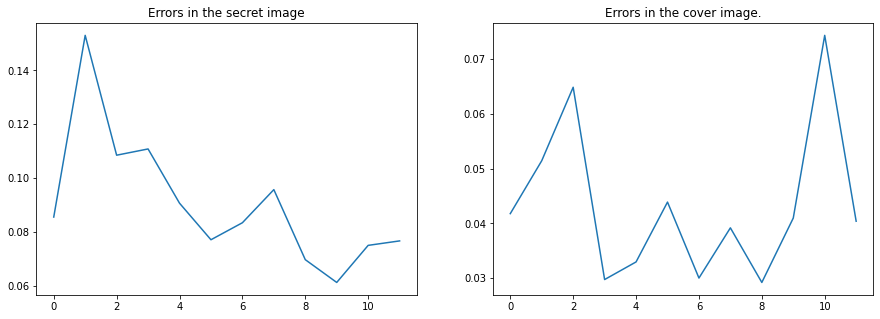

In [29]:
# Plot distribution of errors in cover and secret images.
plot.plot_error(S_error, C_error)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cover image: kodim13.png, Secret image: kodim01.png
Total loss: 0.13 
Loss on secret: 0.09 
Loss on cover: 0.04


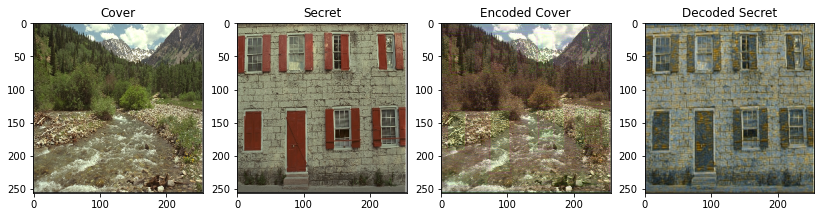

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cover image: kodim14.png, Secret image: kodim02.png
Total loss: 0.20 
Loss on secret: 0.15 
Loss on cover: 0.05


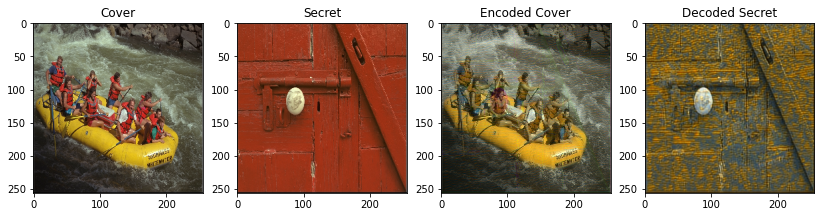

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cover image: kodim15.png, Secret image: kodim03.png
Total loss: 0.17 
Loss on secret: 0.11 
Loss on cover: 0.06


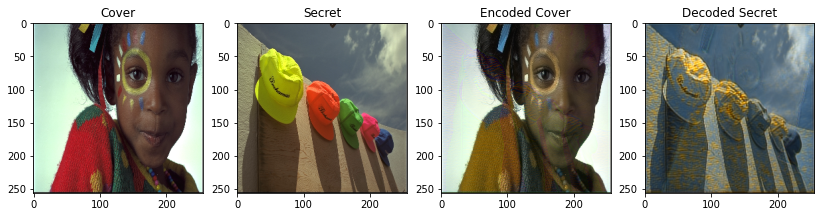

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cover image: kodim16.png, Secret image: kodim04.png
Total loss: 0.14 
Loss on secret: 0.11 
Loss on cover: 0.03


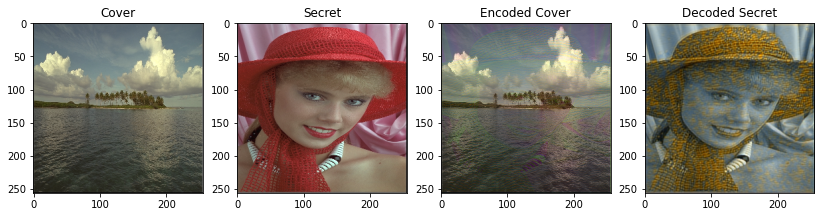

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cover image: kodim17.png, Secret image: kodim05.png
Total loss: 0.12 
Loss on secret: 0.09 
Loss on cover: 0.03


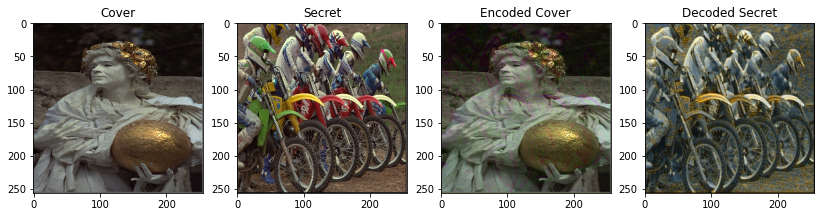

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cover image: kodim18.png, Secret image: kodim06.png
Total loss: 0.12 
Loss on secret: 0.08 
Loss on cover: 0.04


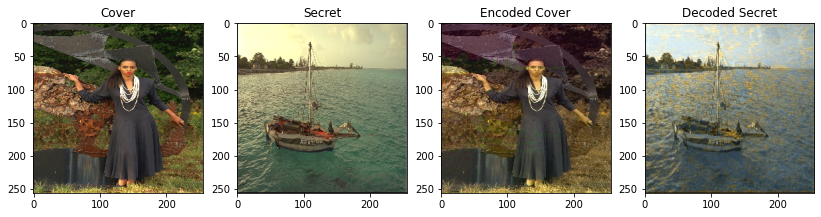

Cover image: kodim19.png, Secret image: kodim07.png
Total loss: 0.11 
Loss on secret: 0.08 
Loss on cover: 0.03


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


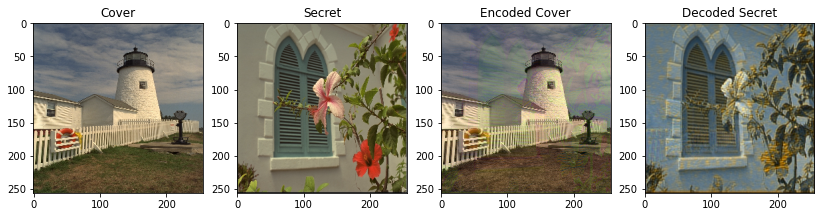

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cover image: kodim20.png, Secret image: kodim08.png
Total loss: 0.13 
Loss on secret: 0.10 
Loss on cover: 0.04


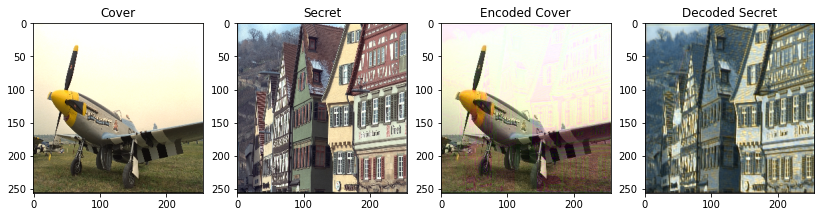

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cover image: kodim21.png, Secret image: kodim09.png
Total loss: 0.10 
Loss on secret: 0.07 
Loss on cover: 0.03


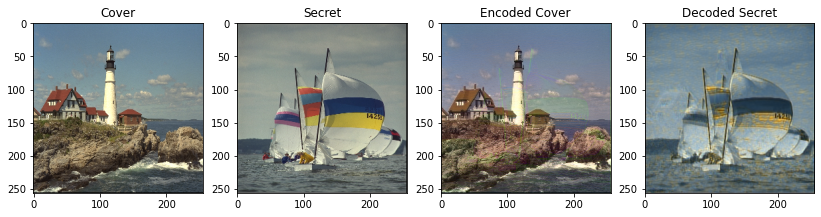

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cover image: kodim22.png, Secret image: kodim10.png
Total loss: 0.10 
Loss on secret: 0.06 
Loss on cover: 0.04


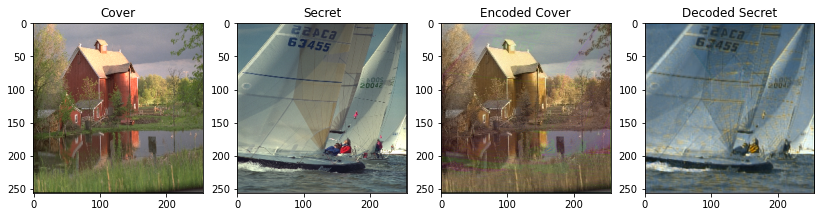

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cover image: kodim23.png, Secret image: kodim11.png
Total loss: 0.15 
Loss on secret: 0.07 
Loss on cover: 0.07


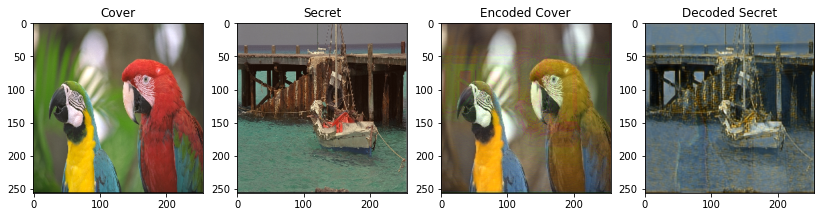

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cover image: kodim24.png, Secret image: kodim12.png
Total loss: 0.12 
Loss on secret: 0.08 
Loss on cover: 0.04


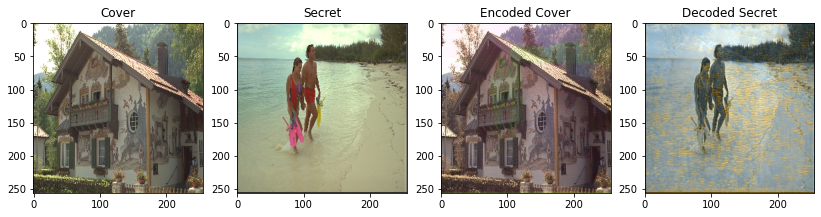

In [30]:
img_names = os.listdir(test_dir)
# Number of secret and cover pairs to show.
n = test_S.shape[0]
indx = [i for i in range(test_S.shape[0])]
# for i, idx in enumerate(range(0, n)):
for idx in indx:
    print('Cover image: '+img_names[idx+12]+', Secret image: '+img_names[idx])
    print('Total loss: {:.2f} \nLoss on secret: {:.2f} \nLoss on cover: {:.2f}'.format(S_error[idx]+C_error[idx], S_error[idx], C_error[idx]))    
    
    plt.figure(figsize=(14, 15))
    
    plot.show_image(test_C[idx], 1, 4, 1, 'Cover')

    plot.show_image(test_S[idx], 1, 4, 2, 'Secret')
    
    plot.show_image(decoded_C[idx], 1, 4,  3, 'Encoded Cover')
    
    plot.show_image(decoded_S[idx], 1, 4, 4, 'Decoded Secret')
    plt.show()